In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [8]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [9]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [10]:
for route in routes:
    add_extra_data(route)

In [11]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [12]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Analytics

## Helper Functions

In [13]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [14]:
import random

def random_date(start, end, prop):
    """
    Generates a random date in between the start and end date given
    """
    
    stime = convert_time_to_datetime(start)
    etime = convert_time_to_datetime(end)

    ptime = stime + prop * (etime - stime)
    return ptime

In [15]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

In [16]:
# Generate random list of request times
def generate_random_request_times(start, end, num_times):
    """
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    
    req_times_random = [random_date(start, end, random.random()) for x in range(num_times)]
    format = '%Y-%m-%d %H:%M:%S'
    req_times_random.sort()
    req_times = [t.strftime(format) for t in req_times_random]
    print(req_times)
    return req_times

## Predict journey time by taking recent information into account 

In [17]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours 
        of the request time. (not including the request time)
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time. Returns -1
        if no vehicle arrived at stop b within the past 2 hours, but before the req_time. This
        could occur in cases where a request is made e.g. at 3 am and the bus is not a 24h bus.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours 
        of the request time. Bus details include vehicle id.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    count1 = 0
    count2 = 0

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        past_2_hours = req_time - dt.timedelta(hours = 2)

        if (arr_dt >= past_2_hours) & (arr_dt < req_time):
            count = count + 1
            # arrived within past 2 hours and before request time
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    # vehicle id matches
                    count1 = count1 + 1
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                        count2 = count2 + 1
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        
    print("Number of buses that arrived at stop b within the past 2 hours: ", count)
    print("Number of buses that left stop a and have an id match: ", count1)
    print("Number of buses that have feasible journey times: ", count2)
        
    return most_recent_left, arrived_journeys, journey_times

In [18]:
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}

def predict_journey_time(req_time, stop_a, stop_b, a_id):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past 2 hours.
    - Journey times from the past 2 hours are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    
    most_recent_left_indx, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, a_id, req_time)
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["time_of_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [19]:
def predict_arrival_time(req_time, leave_stop, pred_jrny_time, most_recent_left):
    """
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred_jrny_time: predicted journey time
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['time_of_arrival'])
            # This vehicle is the one that left immediately after

            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred_jrny_time + 30))
                return pred_arrival, bus
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data
#             break
                
    # most_recent_left is the last item in the list already
    print("There are no buses due at this time from this stop")    
    return 0, []

In [20]:
def get_actual_times(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the arrival time and journey time of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    [bus_id, a_id, date, direction, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_' + direction + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                if (actual_jrny_time > dt.timedelta(minutes = 10)) or (actual_jrny_time < dt.timedelta(minutes = 3)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                print("Actual arrival time is {}".format(actual_arr_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [21]:
def pred_eval_arrival_times_mult(req_time, stop_a, stop_b, a_id, b_id):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B.
    If the actual bus data cannot be found, the actual arrival time = 0.
    
    """
    
    print("Request time is ", req_time)
    
    pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a, stop_b, a_id)
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        print("Couldn't find any journeys")
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        print("Cannot find correlating leaving bus.")
        return pred_arr, 0, 0, 0
    
    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr, actual_jrny_time = get_actual_times(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        print("There is no bus arriving at req_time")
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

### Route 52 Gap of 5: Chesterton Road to Nottinghill Gate Station (inbound)

I am at Nottinghill Gate Station and I want to know what time the next bus will arrive. The current time is X.

I look back 5 stops to find stop A which is the stop which I will use to predict the journey time. Here stop A = Chesterton Road.

I look at the other buses that have left Chesterton Road and arrived at Nottinghill Gate Station in the past 2 hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes. Then calculate this weighted average as the predicted journey time for a bus travelling between Chesterton Road and Nottinghill Gate. **predicted journey time = weighted average of past 2 hours of journey times**

I now try to get the predicted arrival time. So I look for the last bus to leave Chesterton Road and arrive at Nottinghill Gate before the request time. Then I get the next immediate bus that leaves Chesterton Road. This is the one that will be used to predict the arrival time. Add the predicted journey time onto the leave time of this bus + 30 seconds loading/unloading time to get the predicted arrival time. **predicted arrival time = leave time + predicted journey time + 30 seconds**. 

If such a bus doesn't exist, then there is no predicted arrival time, but there is still the predicted journey time. E.g. if I request the time that the nearest bus will arrive at Nottinghill Gate at 03:16:27, then I gather all the buses that arrived at Nottinghill Gate within the past 2 hours that arrived BEFORE 03:16:27. Say the last bus that left Chesterton Road left at 02:45 and arrived at Nottinghill Gate at 03:15. So to get the predicted arrival time, I try to find the next bus to leave Chesterton Road, which is a bus that leaves at 03:17. This time is AFTER the request time so I cannot use this bus in the prediction because it is not the historical data.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

I now get the actual arrival time. The same bus that we used to calculate the predicted arrival time, we track its vehicle id in the entries for Nottinghill Gate and look for its actual arrival time. Get the actual journey time by subtracting the leave time from the actual arrival time. **actual journey time = actual arrival time - leave time**

To evaluate success, plot the predicted journey journey time against the actual journey time and could calculate the MAPE or something along those lines.

In [28]:
stop_a_name52 = stops_in_sequence_inbound.get("52")[16]
stop_b_name52 = stops_in_sequence_inbound.get("52")[21]

print(stop_a_name52, stops_in_sequence_inbound.get("52").index("Chesterton Road"))
print(stop_b_name52, stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

Chesterton Road 16
Notting Hill Gate Station 21


In [29]:
b_52 = data["52"]

stop_a52 = b_52.loc[(b_52['bus_stop_name'] == stop_a_name52) & (b_52['direction'] == 'inbound')]
[_, stop_a_id52, _, _, _] = stop_a52.iloc[0]['vehicle_id'].split('_')
print(stop_a52.shape)
print(stop_a_id52)
stop_a52.head()

(1351, 5)
490005139C


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
50,Chesterton Road,2020-04-16 02:53:40,11536_490005139C_2020-04-16_out_0,2020-04-16 02:49:22,inbound
51,Chesterton Road,2020-04-16 02:53:40,11536_490005139C_2020-04-16_out_0,2020-04-16 02:49:22,inbound
198,Chesterton Road,2020-04-16 03:24:17,10292_490005139C_2020-04-16_out_0,2020-04-16 03:21:47,inbound
199,Chesterton Road,2020-04-16 03:24:17,10292_490005139C_2020-04-16_out_0,2020-04-16 03:21:47,inbound
296,Chesterton Road,2020-04-16 03:41:35,11808_490005139C_2020-04-16_out_0,2020-04-16 03:40:29,inbound


In [30]:
stop_b52 = b_52.loc[(b_52['bus_stop_name'] == stop_b_name52) & (b_52['direction'] == 'inbound')]
[_, stop_b_id52, _, _, _] = stop_b52.iloc[0]['vehicle_id'].split('_')
print(stop_b52.shape)
print(stop_b_id52)
stop_b52.head()

(1360, 5)
490000167G


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
70,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
71,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
216,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
217,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
330,Notting Hill Gate Station,2020-04-16 03:45:43,11808_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound


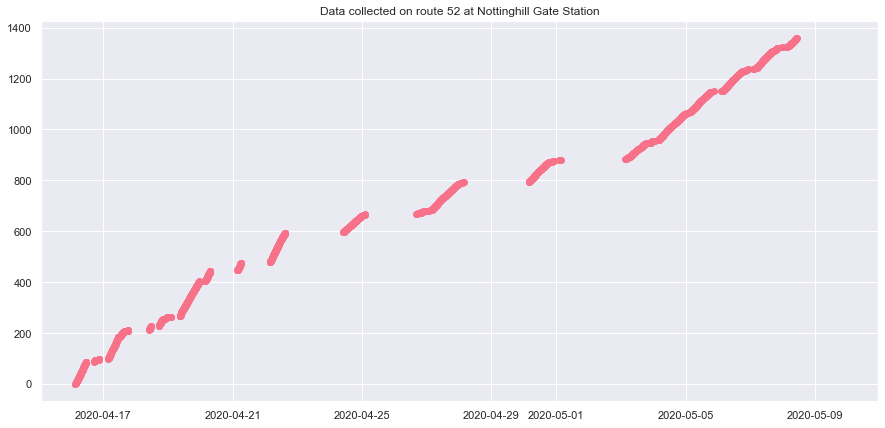

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 52 at Nottinghill Gate Station")
plt.show()

In [33]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times
accs_52 = actual arrival times
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (in minutes)
accs_jrny_52 = actual journey times (in minutes)
"""

preds_52 = []
accs_52 = []
req_times_52 = generate_random_request_times("2020-05-03 02:00:00", "2020-05-08 23:59:59", 200)
req_timesx_52 = []
preds_jrny_52 = []
accs_jrny_52 = []

start = time.time()
for req_time in req_times_52:
    pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, stop_a52, stop_b52, stop_a_id52, stop_b_id52)
    if at == 0:
        continue
        
    req_timesx_52.append(req_time)
    preds_52.append(pt)
    accs_52.append(at)
    preds_jrny_52.append(pj / 60)
    accs_jrny_52.append(aj / 60)
print("Total time taken: ", (time.time() - start))

['2020-05-03 02:34:43', '2020-05-03 03:52:08', '2020-05-03 05:49:27', '2020-05-03 05:56:46', '2020-05-03 07:48:49', '2020-05-03 08:23:51', '2020-05-03 08:48:04', '2020-05-03 09:27:22', '2020-05-03 09:38:12', '2020-05-03 09:51:40', '2020-05-03 10:07:16', '2020-05-03 11:57:27', '2020-05-03 12:00:44', '2020-05-03 13:09:30', '2020-05-03 14:39:43', '2020-05-03 15:23:55', '2020-05-03 16:13:58', '2020-05-03 16:16:02', '2020-05-03 16:23:44', '2020-05-03 16:57:54', '2020-05-03 18:02:07', '2020-05-03 19:40:18', '2020-05-03 20:02:51', '2020-05-03 20:39:44', '2020-05-03 20:42:21', '2020-05-03 20:51:28', '2020-05-03 21:31:21', '2020-05-03 22:19:56', '2020-05-03 22:48:56', '2020-05-04 00:21:34', '2020-05-04 00:46:31', '2020-05-04 01:28:27', '2020-05-04 02:28:51', '2020-05-04 03:21:30', '2020-05-04 03:48:34', '2020-05-04 04:07:57', '2020-05-04 04:15:51', '2020-05-04 04:20:47', '2020-05-04 04:48:43', '2020-05-04 05:13:59', '2020-05-04 05:48:46', '2020-05-04 06:13:28', '2020-05-04 06:16:11', '2020-05-0

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  11
Predicted journey time is  5.522865013774106
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-03 12:00:44
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  11
Predicted journey time is  5.491884057971016
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-03 13:09:30
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  48
Number of buses that have feasible journey times:  9
Predicted journey time is  6.841111111111112
Predicted arrival time is 2020-05-03 13:10:45.466667
There is no bus arriv

Actual journey time is 0:07:27
Actual arrival time is 2020-05-04 04:09:17
Request time is  2020-05-04 04:15:51
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  4
Predicted journey time is  6.198809523809524
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 04:20:47
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  4
Predicted journey time is  5.662244897959184
Predicted arrival time is 2020-05-04 04:25:37.734694
Actual journey time is 0:04:53
Actual arrival time is 2020-05-04 04:23:51
Request time is  2020-05-04 04:48:43
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  55
Number of buses that have 

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  73
Number of buses that have feasible journey times:  9
Predicted journey time is  4.521212121212121
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 17:45:56
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  62
Number of buses that have feasible journey times:  8
Predicted journey time is  4.503516819571866
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 17:56:49
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  70
Number of buses that have feasible journey times:  9
Predicted journey time is  5.175757575757576
Predicted arrival time is 2020-05-04 18:00:12.545455
Actual journey time is 0:

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  72
Number of buses that have feasible journey times:  10
Predicted journey time is  5.127884615384615
Predicted arrival time is 2020-05-05 10:33:16.673077
There is no bus arriving at req_time
Request time is  2020-05-05 12:21:10
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  9
Predicted journey time is  7.8182222222222215
Predicted arrival time is 2020-05-05 12:24:48.093333
Actual journey time is 0:06:53
Actual arrival time is 2020-05-05 12:22:52
Request time is  2020-05-05 15:09:47
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  10
Predicted journey time is  6.8480874316939895
Predicted arrival time is 2020

Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  2
Predicted journey time is  4.321568627450981
Predicted arrival time is 2020-05-06 04:06:43.294118
Actual journey time is 0:04:45
Actual arrival time is 2020-05-06 04:06:09
Request time is  2020-05-06 04:48:02
Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey times:  5
Predicted journey time is  4.595528455284553
Predicted arrival time is 2020-05-06 04:51:20.731707
Actual journey time is 0:04:20
Actual arrival time is 2020-05-06 04:50:05
Request time is  2020-05-06 05:12:00
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  8
Predicted journey time is  3.7505509641873274

Actual journey time is 0:06:01
Actual arrival time is 2020-05-06 18:03:43
Request time is  2020-05-06 18:04:27
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  9
Predicted journey time is  5.609545454545454
Predicted arrival time is 2020-05-06 18:04:46.572727
There is no bus arriving at req_time
Request time is  2020-05-06 19:30:17
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  3
Predicted journey time is  5.327777777777778
Predicted arrival time is 2020-05-06 18:04:29.666667
There is no bus arriving at req_time
Request time is  2020-05-06 19:34:05
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  3
Predicte

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  70
Number of buses that have feasible journey times:  11
Predicted journey time is  6.358953168044077
Predicted arrival time is 2020-05-07 12:28:50.537190
There is no bus arriving at req_time
Request time is  2020-05-07 12:22:47
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  70
Number of buses that have feasible journey times:  11
Predicted journey time is  6.358953168044077
Predicted arrival time is 2020-05-07 12:28:50.537190
There is no bus arriving at req_time
Request time is  2020-05-07 13:30:41
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  64
Number of buses that have feasible journey times:  10
Predicted journey time is  5.962841530054646
Predicted arrival time is 2020-05-07 13:35:53.770492
Actual journey 

Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  5.783333333333333
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-08 13:13:31
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 13:51:00
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 13:59:19
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and ha

In [34]:
len(preds_jrny_52)

50

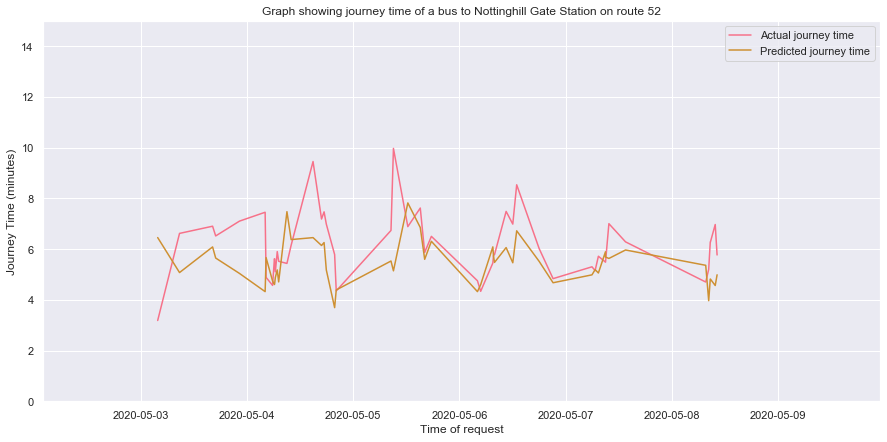

In [40]:
times_52 = [convert_time_to_datetime(t) for t in req_timesx_52]
actual_jrny_52 = [x.total_seconds() for x in accs_jrny_52]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52, actual_jrny_52, label="Actual journey time")
ax.plot(times_52, preds_jrny_52, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 2, 2), dt.datetime(2020, 5, 9, 22, 59, 59)])
ax.set_title("Graph showing journey time of a bus to Nottinghill Gate Station on route 52")
ax.legend()

plt.show()

### Measuring Success

**Explained variance regression score function**: Best possible score is 1.0, lower values are worse. https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 

**Mean Absolute Percentage Error:** (MAPE). Best is 100, lower values are worse.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

In [41]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

actual_seconds_52 = [a.timestamp() for a in accs_52]
pred_seconds_52 = [p.timestamp() for p in preds_52]

evs52 = explained_variance_score(actual_seconds_52, pred_seconds_52)
mape52 = mean_absolute_error(actual_seconds_52, pred_seconds_52)

print("Explain variance score: ", evs52)
print("Mean absolute percentage error: ", mape52)

Explain variance score:  0.9999996648301778
Mean absolute percentage error:  57.70449606895447


### Different gaps for predictions for bus route 52

Experiment with different gaps to report back

In [42]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a_gaps = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a_gaps)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [43]:
stop_a_entries = b_52.loc[(b_52['bus_stop_name'] == stop_a_gaps) & (b_52['direction'] == 'inbound')]
[_, stop_a_id_gaps, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id_gaps)

(1208, 5)
490014687E


In [44]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps = []
full_actual_varying_gaps = []
full_req_varying_gaps = []

req_times_52 = generate_random_request_times("2020-05-03 03:00:00", "2020-05-08 23:59:59", 200)

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')

    preds_52 = []
    accs_52 = []
    req_timesx_52 = []

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, stop_a_entries, stop_b_entries, stop_a_id_gaps, stop_b_id_gaps)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
        
    full_preds_varying_gaps.append(preds_52)
    full_actual_varying_gaps.append(accs_52)
    full_req_varying_gaps.append(req_timesx_52)

['2020-05-03 03:19:32', '2020-05-03 04:13:28', '2020-05-03 08:14:33', '2020-05-03 08:15:21', '2020-05-03 08:19:12', '2020-05-03 09:32:55', '2020-05-03 09:43:53', '2020-05-03 09:47:16', '2020-05-03 10:23:27', '2020-05-03 10:34:48', '2020-05-03 11:21:28', '2020-05-03 11:53:43', '2020-05-03 13:36:27', '2020-05-03 14:38:44', '2020-05-03 15:20:31', '2020-05-03 16:07:12', '2020-05-03 17:21:22', '2020-05-03 17:32:16', '2020-05-03 17:41:47', '2020-05-03 18:38:54', '2020-05-03 19:13:13', '2020-05-03 19:15:35', '2020-05-03 21:39:13', '2020-05-03 22:48:29', '2020-05-03 23:06:46', '2020-05-03 23:49:45', '2020-05-04 01:38:59', '2020-05-04 02:22:22', '2020-05-04 03:15:32', '2020-05-04 03:31:49', '2020-05-04 04:06:40', '2020-05-04 04:07:08', '2020-05-04 05:29:14', '2020-05-04 05:40:15', '2020-05-04 06:40:27', '2020-05-04 06:40:30', '2020-05-04 06:49:49', '2020-05-04 10:26:12', '2020-05-04 11:03:22', '2020-05-04 12:54:38', '2020-05-04 13:40:54', '2020-05-04 14:13:27', '2020-05-04 16:45:53', '2020-05-0

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  8
Predicted journey time is  6.694209039548022
Predicted arrival time is 2020-05-03 11:28:36.652542
Actual journey time is 0:06:35
Actual arrival time is 2020-05-03 11:27:30
Request time is  2020-05-03 11:53:43
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  11
Predicted journey time is  6.613498622589532
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-03 13:36:27
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  45
Number of buses that have feasible journey times:  8
Predicted journey time is  6.494871794871795
There are no buses due at this time f

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  78
Number of buses that have feasible journey times:  10
Predicted journey time is  7.236280487804877
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 06:40:30
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  78
Number of buses that have feasible journey times:  10
Predicted journey time is  7.236280487804877
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 06:49:49
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  83
Number of buses that have feasible journey times:  10
Predicted journey time is  7.344910179640718
There are no buses due at this time from this stop
Cannot find correlati

Actual journey time is 0:05:43
Actual arrival time is 2020-05-04 21:06:21
Request time is  2020-05-04 21:33:43
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  70
Number of buses that have feasible journey times:  9
Predicted journey time is  5.20280701754386
Predicted arrival time is 2020-05-04 21:38:03.168421
Actual journey time is 0:06:16
Actual arrival time is 2020-05-04 21:38:07
Request time is  2020-05-04 22:07:51
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  8
Predicted journey time is  5.438823529411764
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 22:22:38
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  56
Number of buses that have 

Actual journey time is 0:08:05
Actual arrival time is 2020-05-05 11:53:19
Request time is  2020-05-05 13:14:42
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  53
Number of buses that have feasible journey times:  10
Predicted journey time is  7.333854166666667
Predicted arrival time is 2020-05-05 13:17:32.031250
Actual journey time is 0:06:58
Actual arrival time is 2020-05-05 13:16:10
Request time is  2020-05-05 13:15:32
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  53
Number of buses that have feasible journey times:  10
Predicted journey time is  7.353278688524591
Predicted arrival time is 2020-05-05 13:17:33.196721
Actual journey time is 0:06:58
Actual arrival time is 2020-05-05 13:16:10
Request time is  2020-05-05 13:20:18
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  9
Predicted journey time is  5.648809523809523
Predicted arrival time is 2020-05-06 06:00:10.928571
Actual journey time is 0:06:38
Actual arrival time is 2020-05-06 06:00:10
Request time is  2020-05-06 06:49:19
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  11
Predicted journey time is  5.3359154929577475
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-06 07:35:18
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  66
Number of buses that have feasible journey times:  11
Predicted journey time is  6.6683908045977
Predicted arrival time is 2020-05-0

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  62
Number of buses that have feasible journey times:  9
Predicted journey time is  6.851769911504425
Predicted arrival time is 2020-05-06 17:00:19.106195
There is no bus arriving at req_time
Request time is  2020-05-06 17:56:36
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  51
Number of buses that have feasible journey times:  7
Predicted journey time is  2.633555555555555
Predicted arrival time is 2020-05-06 17:58:54.013333
There is no bus arriving at req_time
Request time is  2020-05-06 18:12:07
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  44
Number of buses that have feasible journey times:  6
Predicted journey time is  4.39920634920635
Predicted arrival time is 2020-05-06 18:00:39.952381
There is no bus arriv

Actual journey time is 0:07:35
Actual arrival time is 2020-05-07 11:42:11
Request time is  2020-05-07 11:57:07
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  9
Predicted journey time is  5.925151515151515
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-07 12:42:10
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  9
Predicted journey time is  7.06426282051282
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-07 12:43:13
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  9
Predicted 

Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  4.198850574712644
Predicted arrival time is 2020-05-08 04:11:15.931034
Actual journey time is 0:05:25
Actual arrival time is 2020-05-08 04:11:29
Request time is  2020-05-08 05:23:16
Number of buses that arrived at stop b within the past 2 hours:  6
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  5
Predicted journey time is  4.996212121212122
Predicted arrival time is 2020-05-08 05:23:48.772727
Actual journey time is 0:06:29
Actual arrival time is 2020-05-08 05:24:18
Request time is  2020-05-08 05:38:34
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  6
Predicted journey time is  5.654814814814815
T

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  8
Predicted journey time is  9.44006116207951
Predicted arrival time is 2020-05-03 08:21:59.403670
Actual journey time is 0:09:30
Actual arrival time is 2020-05-03 08:21:03
Request time is  2020-05-03 08:19:12
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  8
Predicted journey time is  9.44006116207951
Predicted arrival time is 2020-05-03 08:21:59.403670
Actual journey time is 0:09:30
Actual arrival time is 2020-05-03 08:21:03
Request time is  2020-05-03 09:32:55
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  50
Number of buses that have feasible journey times:  9
Predicted journey time is  9.167948717948718
Th

Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  1
Predicted journey time is  7.933333333333333
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-04 03:15:32
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 03:31:49
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 04:06:40
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and 

There is no bus arriving at req_time
Request time is  2020-05-04 19:24:21
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  76
Number of buses that have feasible journey times:  9
Predicted journey time is  10.362654320987653
Predicted arrival time is 2020-05-04 19:31:23.759259
Actual journey time is 0:09:40
Actual arrival time is 2020-05-04 19:29:42
Request time is  2020-05-04 19:39:49
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  69
Number of buses that have feasible journey times:  8
Predicted journey time is  9.741999999999999
Predicted arrival time is 2020-05-04 19:42:46.520000
There is no bus arriving at req_time
Request time is  2020-05-04 19:44:57
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  9
Predi

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  10
Predicted journey time is  10.704232804232806
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-05 08:26:45
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  10
Predicted journey time is  11.665954415954417
Predicted arrival time is 2020-05-05 08:33:59.957265
There is no bus arriving at req_time
Request time is  2020-05-05 08:35:13
Number of buses that arrived at stop b within the past 2 hours:  13
Number of buses that left stop a and have an id match:  69
Number of buses that have feasible journey times:  11
Predicted journey time is  11.992699724517907
Predicted arrival time is 2020-05-05 08:44:42.561983
Actual journey

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 03:46:44
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  8.133333333333333
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-06 03:56:06
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  8.133333333333333
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-06 04:04:45
Number of buses that arrived at

There is no bus arriving at req_time
Request time is  2020-05-06 15:34:41
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  9
Predicted journey time is  11.747543859649124
Predicted arrival time is 2020-05-06 15:46:19.852632
There is no bus arriving at req_time
Request time is  2020-05-06 15:53:38
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  9
Predicted journey time is  11.483493589743587
Predicted arrival time is 2020-05-06 15:57:36.009615
There is no bus arriving at req_time
Request time is  2020-05-06 16:11:19
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  9
Predicted journey time is  12.4116379310

Actual journey time is 0:08:16
Actual arrival time is 2020-05-07 10:20:22
Request time is  2020-05-07 10:56:50
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  10
Predicted journey time is  8.895628415300546
Predicted arrival time is 2020-05-07 10:55:00.737705
There is no bus arriving at req_time
Request time is  2020-05-07 11:15:13
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  11
Predicted journey time is  11.220535714285713
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-07 11:17:03
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  11
Pre

Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 02:12:41
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 02:20:41
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 02:51:52
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 23:48:26
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 03:19:32
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  10.983333333333333
Predicted arrival time is 2020-05-03 03:23:36
There is no bus arriving at req_time
Request time is  2020-05-03 04:13:28
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have a

Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  3
Predicted journey time is  12.157407407407408
Predicted arrival time is 2020-05-03 22:44:55.444444
There is no bus arriving at req_time
Request time is  2020-05-03 23:06:46
Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  3
Predicted journey time is  12.15740740740741
Predicted arrival time is 2020-05-03 22:44:55.444444
There is no bus arriving at req_time
Request time is  2020-05-03 23:49:45
Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  4
Predicted journey time is  12.025
There are no buses due at this time from this stop
Cannot find correlating leaving b

There is no bus arriving at req_time
Request time is  2020-05-04 18:25:37
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  72
Number of buses that have feasible journey times:  1
Predicted journey time is  12.966666666666669
Predicted arrival time is 2020-05-04 18:08:04
There is no bus arriving at req_time
Request time is  2020-05-04 18:57:23
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  76
Number of buses that have feasible journey times:  3
Predicted journey time is  13.64176029962547
Predicted arrival time is 2020-05-04 19:10:55.505618
There is no bus arriving at req_time
Request time is  2020-05-04 19:00:47
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  76
Number of buses that have feasible journey times:  3
Predicted journey time is  13.64176029962547
Pre

There is no bus arriving at req_time
Request time is  2020-05-05 06:19:25
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  5
Predicted journey time is  11.195652173913043
Predicted arrival time is 2020-05-05 06:04:50.739130
There is no bus arriving at req_time
Request time is  2020-05-05 06:34:53
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  6
Predicted journey time is  12.858783783783784
Predicted arrival time is 2020-05-05 06:37:07.527027
There is no bus arriving at req_time
Request time is  2020-05-05 07:05:57
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  4
Predicted journey time is  12.47187500000

Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 03:46:44
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 03:56:06
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 04:04:45
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  0
Pre

There is no bus arriving at req_time
Request time is  2020-05-06 15:53:38
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  1
Predicted journey time is  14.05
Predicted arrival time is 2020-05-06 14:12:10
There is no bus arriving at req_time
Request time is  2020-05-06 16:11:19
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 16:22:38
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 16:30:23
Number of buses that arrived at stop b with

There is no bus arriving at req_time
Request time is  2020-05-07 11:17:03
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  7
Predicted journey time is  13.393548387096773
Predicted arrival time is 2020-05-07 10:59:30.612903
There is no bus arriving at req_time
Request time is  2020-05-07 11:22:18
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  7
Predicted journey time is  13.04
Predicted arrival time is 2020-05-07 10:59:09.400000
There is no bus arriving at req_time
Request time is  2020-05-07 11:40:49
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  62
Number of buses that have feasible journey times:  6
Predicted journey time is  13.34481981981982
Predicte

Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 04:06:02
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  9.894791666666666
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-08 04:09:23
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  9.894791666666666
Predicted arrival time is 2020-05-08 04:16:57.687500
There is no bus arriving at req_time
Request time is  2020-05-08 05:23:16
Number of buses that arrived 

There is no bus arriving at req_time
Request time is  2020-05-03 08:14:33
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 08:15:21
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 08:19:12
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  50
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 09:32:55
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a an

Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 05:29:14
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  1
Predicted journey time is  13.716666666666669
Predicted arrival time is 2020-05-04 05:20:41
There is no bus arriving at req_time
Request time is  2020-05-04 05:40:15
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  76
Number of buses that have feasible journey times:  1
Predicted journey time is  13.716666666666669
Predicted arrival time is 2020-05-04 05:20:41
There is no bus arriving at req_time
Request time is  2020-05-04 06:40:27
Number of buses that arrived at sto

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 22:30:56
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  1
Predicted journey time is  14.216666666666667
Predicted arrival time is 2020-05-04 22:34:47
There is no bus arriving at req_time
Request time is  2020-05-04 23:00:47
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times:  2
Predicted journey time is  14.419047619047621
Predicted arrival time is 2020-05-04 22:59:08.142857
There is no bus arriving at req_time
Request time is  2020-05-04 23:09:10
Number of buses that arriv

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 19:10:33
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 19:12:28
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 19:22:15
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  40
Number of buses that have feasible journey times:  

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 12:24:06
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 12:32:33
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  62
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 14:03:26
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  64
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 10:56:50
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 11:15:13
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 11:17:03
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 04:06:02
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  11.666666666666666
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-08 04:09:23
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  11.666666666666666
Predicted arrival time is 2020-05-08 04:18:44
There is no bus arriving at req_time
Request time is  2020-05-08 05:23:16
Number of buses that arrived at st

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  48
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 09:32:55
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 09:43:53
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  53
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 09:47:16
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  51
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  80
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 06:40:30
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  80
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 06:49:49
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 10:26:12
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  82
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 23:59:15
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 00:23:41
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  52
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 01:32:13
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  0

Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 23:14:41
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 23:37:45
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 23:52:23
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
P

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 16:11:19
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  58
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 16:22:38
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 16:30:23
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 13:25:42
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 13:47:00
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 13:53:15
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  52
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 10:27:08
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  31
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 11:36:43
Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  14
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 12:47:18
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  

Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  32
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 16:07:12
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  51
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 17:21:22
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  52
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 17:32:16
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  50
Number of buses that have feasible journey times:  

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  73
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 17:32:27
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 17:35:55
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 18:24:48
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 08:26:45
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  62
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 08:35:13
Number of buses that arrived at stop b within the past 2 hours:  13
Number of buses that left stop a and have an id match:  69
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 10:15:09
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  66
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  45
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 05:56:26
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  47
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 06:49:19
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 07:35:18
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  64
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  6
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 00:50:44
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 01:57:05
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 02:28:13
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  0
Pr

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  47
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 20:12:34
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  37
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 22:06:01
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 22:58:18
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0


Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 18:44:13
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 19:25:00
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 19:38:21
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-03 23:49:45
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  33
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 01:38:59
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 02:22:22
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0


Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  73
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 20:58:37
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  82
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 21:05:52
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  84
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-04 21:33:43
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 17:44:44
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  53
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 18:10:08
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 19:10:33
Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  37
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  71
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 11:58:04
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 12:14:58
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 12:24:06
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  70
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 10:02:00
Number of buses that arrived at stop b within the past 2 hours:  13
Number of buses that left stop a and have an id match:  73
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 10:13:24
Number of buses that arrived at stop b within the past 2 hours:  13
Number of buses that left stop a and have an id match:  78
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 10:56:50
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 04:06:02
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 04:09:23
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-08 05:23:16
Number of buses that arrived at stop b within the past 2 hours:  6
Number of buses that left stop a and have an id match:  20
Number of buses that have feasible journey times:  0
Pr

63


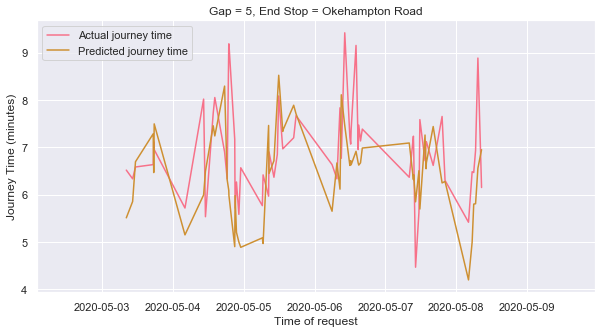

22


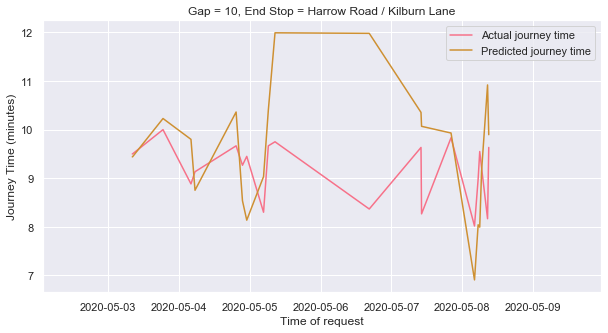

0


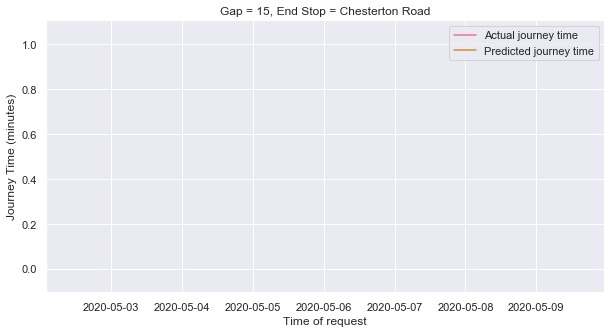

0


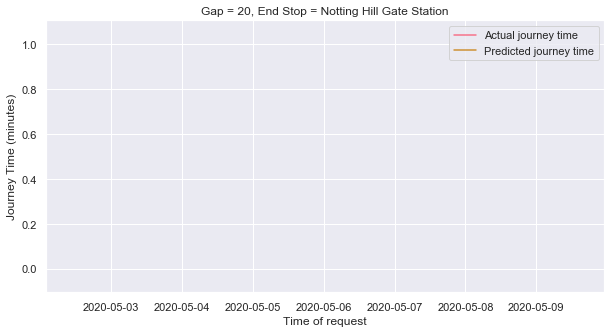

0


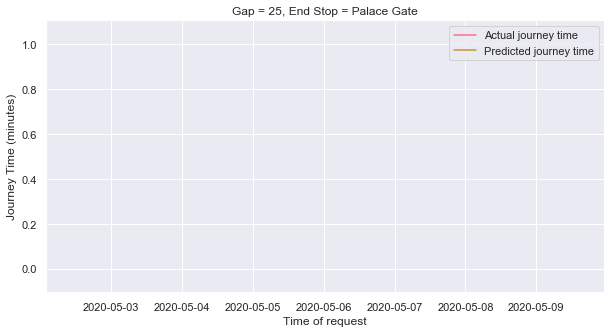

0


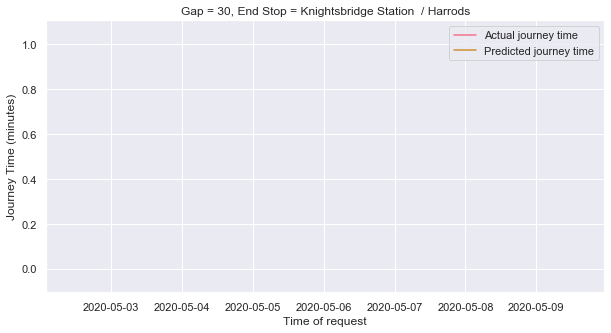

0


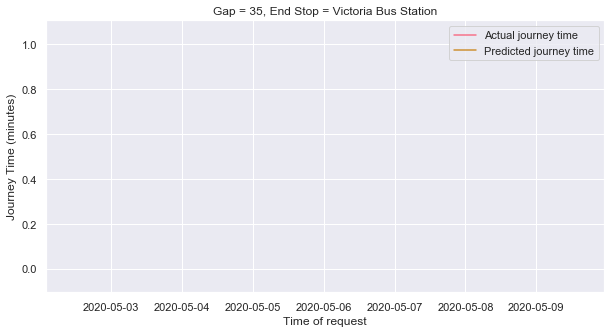

In [46]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = [x.total_seconds() for x in full_actual_varying_gaps[i]]
    t = full_req_varying_gaps[i]
    r = [convert_time_to_datetime(x) for x in t]
    print(len(p))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(r, a, label="Actual journey time")
    ax.plot(r, p, label="Predicted journey time")
    ax.set_xlabel("Time of request")
    ax.set_ylabel("Journey Time (minutes)")
    ax.set_xlim([dt.datetime(2020, 5, 2, 2), dt.datetime(2020, 5, 9, 22, 59, 59)])
    ax.set_title("Gap = {}, End Stop = {}".format((i + 1) * 5, destination_stops[i]))
    ax.legend()
    plt.show()

In [50]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = full_actual_varying_gaps[i]
    t = full_req_varying_gaps[i]
    actual_seconds_52 = [x.timestamp() for x in a]
    pred_seconds_52 = [x.timestamp() for x in p]
    evs = explained_variance_score(actual_seconds_52, pred_seconds_52)
    mape = mean_absolute_error(actual_seconds_52, pred_seconds_52)

    print("Gap = {} Explain variance score = {}, MAPE = ".format((i + 1) * 5, evs, mape))

AttributeError: 'datetime.timedelta' object has no attribute 'timestamp'

### Route 9 Gap of 5: North End Road to Phillimore Gardens (inbound)

In [51]:
stop_a_name9 = stops_in_sequence_inbound.get("9")[3]
stop_b_name9 = stops_in_sequence_inbound.get("9")[8]

print(stop_a_name9, stops_in_sequence_inbound.get("9").index("North End Road"))
print(stop_b_name9, stops_in_sequence_inbound.get("9").index("Phillimore Gardens"))

North End Road 3
Phillimore Gardens 8


In [52]:
b_9 = data["9"]

stop_a9 = b_9.loc[(b_9['bus_stop_name'] == stop_a_name9) & (b_9['direction'] == 'inbound')]
[_, stop_a_id9, _, _, _] = stop_a9.iloc[0]['vehicle_id'].split('_')
print(stop_a9.shape)
print(stop_a_id9)
stop_a9.head()

(882, 5)
490010357F


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,North End Road,2020-03-10 10:00:50,15447_490010357F_2020-03-10_out_0,2020-03-10 10:01:02,inbound
115,North End Road,2020-03-10 10:25:02,15460_490010357F_2020-03-10_out_0,2020-03-10 10:24:39,inbound
146,North End Road,2020-03-10 10:29:40,14575_490010357F_2020-03-10_out_0,2020-03-10 10:29:38,inbound
193,North End Road,2020-03-10 10:38:36,14537_490010357F_2020-03-10_out_0,2020-03-10 10:38:53,inbound
245,North End Road,2020-03-10 10:46:27,14558_490010357F_2020-03-10_out_0,2020-03-10 10:46:27,inbound


In [53]:
stop_b9 = b_9.loc[(b_9['bus_stop_name'] == stop_b_name9) & (b_9['direction'] == 'inbound')]
[_, stop_b_id9, _, _, _] = stop_b9.iloc[0]['vehicle_id'].split('_')
print(stop_b9.shape)
print(stop_b_id9)
stop_b9.head()

(902, 5)
490010984T


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
14,Phillimore Gardens,2020-03-10 10:03:25,14468_490010984T_2020-03-10_out_0,2020-03-10 10:02:58,inbound
172,Phillimore Gardens,2020-03-10 10:34:34,15460_490010984T_2020-03-10_out_0,2020-03-10 10:33:11,inbound
208,Phillimore Gardens,2020-03-10 10:40:23,14575_490010984T_2020-03-10_out_0,2020-03-10 10:39:37,inbound
255,Phillimore Gardens,2020-03-10 10:48:13,14537_490010984T_2020-03-10_out_0,2020-03-10 10:47:33,inbound
299,Phillimore Gardens,2020-03-10 10:54:47,14558_490010984T_2020-03-10_out_0,2020-03-10 10:52:57,inbound


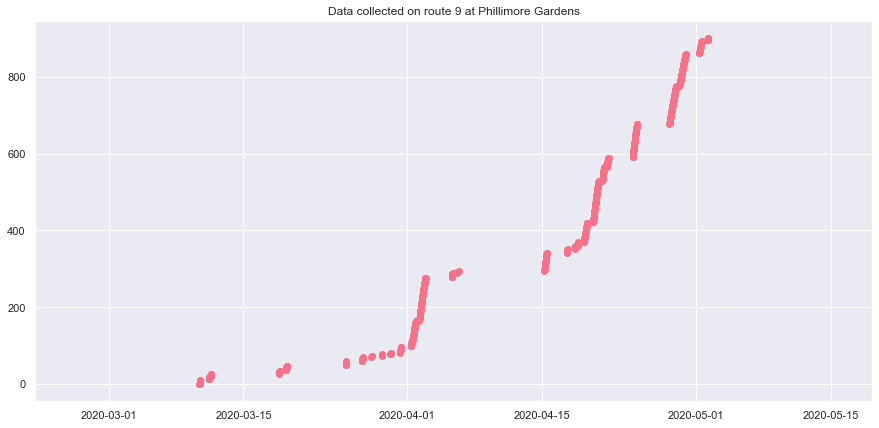

In [54]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b9['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 9 at Phillimore Gardens")
plt.show()

In [55]:
# Getting predicted arrival times for buses on route 9 for a gap of 5 stops.
"""
preds_9 = predicted arrival times
accs_9 = actual arrival times
req_timesx_9 = request times that returned valid values
preds_jrny_9 = predicted journey times (in minutes)
accs_jrny_9 = actual journey times (in minutes)
"""

preds_9 = []
accs_9 = []
req_times_9 = generate_random_request_times("2020-04-16 03:00:00", "2020-04-30 23:59:59", 200)
req_timesx_9 = []
preds_jrny_9 = []
accs_jrny_9 = []

start = time.time()
for req_time in req_times_9:
    pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, stop_a9, stop_b9, stop_a_id9, stop_b_id9)
    if at == 0:
        continue
        
    req_timesx_9.append(req_time)
    preds_9.append(pt)
    accs_9.append(at)
    preds_jrny_9.append(pj / 60)
    accs_jrny_9.append(aj / 60)
print("Total time taken: ", (time.time() - start))

['2020-04-16 03:11:09', '2020-04-16 05:21:55', '2020-04-16 06:20:27', '2020-04-16 06:55:51', '2020-04-16 13:52:25', '2020-04-16 15:32:06', '2020-04-16 15:37:48', '2020-04-16 16:01:10', '2020-04-16 16:25:23', '2020-04-16 16:34:07', '2020-04-16 16:35:37', '2020-04-16 16:36:50', '2020-04-16 19:00:09', '2020-04-16 20:01:11', '2020-04-16 20:34:14', '2020-04-17 00:51:52', '2020-04-17 02:32:55', '2020-04-17 02:43:34', '2020-04-17 04:02:31', '2020-04-17 05:55:55', '2020-04-17 09:50:45', '2020-04-17 10:41:01', '2020-04-17 11:18:12', '2020-04-17 11:53:26', '2020-04-17 17:43:20', '2020-04-17 18:32:00', '2020-04-17 18:39:42', '2020-04-17 18:40:28', '2020-04-17 20:28:58', '2020-04-17 20:54:10', '2020-04-17 21:12:42', '2020-04-17 22:05:29', '2020-04-17 22:05:57', '2020-04-17 22:27:16', '2020-04-18 07:50:13', '2020-04-18 08:22:24', '2020-04-18 10:28:29', '2020-04-18 10:41:26', '2020-04-18 12:16:52', '2020-04-18 12:25:11', '2020-04-18 13:35:10', '2020-04-18 14:13:53', '2020-04-18 15:44:49', '2020-04-1

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 02:32:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 02:43:34
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 04:02:31
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  5
Predicted journey time is  5.613333333333332
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-18 22:28:40
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-18 23:51:10
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-19 03:04:07
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and ha

Number of buses that arrived at stop b within the past 2 hours:  15
Number of buses that left stop a and have an id match:  91
Number of buses that have feasible journey times:  15
Predicted journey time is  3.260572139303483
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-20 17:35:45
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  83
Number of buses that have feasible journey times:  14
Predicted journey time is  4.685384615384617
Predicted arrival time is 2020-04-20 17:38:17.123077
Actual journey time is 0:05:23
Actual arrival time is 2020-04-20 17:37:59
Request time is  2020-04-20 17:41:38
Number of buses that arrived at stop b within the past 2 hours:  15
Number of buses that left stop a and have an id match:  91
Number of buses that have feasible journey times:  15
Predicted journey time is  4.503947368421053
There are no buses due at this ti

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-22 09:13:15
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-22 09:20:53
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-22 09:47:23
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  21
Number of buses that have feasible journey times:  4
Predicted journey time is  5.157526881720431
Predicted arrival time is 2020-04-24 10:30:52.451613
Actual journey time is 0:05:16
Actual arrival time is 2020-04-24 10:29:59
Request time is  2020-04-24 16:35:16
Number of buses that arrived at stop b within the past 2 hours:  16
Number of buses that left stop a and have an id match:  74
Number of buses that have feasible journey times:  16
Predicted journey time is  5.392525252525252
Predicted arrival time is 2020-04-24 16:36:44.551515
Actual journey time is 0:08:14
Actual arrival time is 2020-04-24 16:38:35
Request time is  2020-04-24 16:40:16
Number of buses that arrived at stop b within the past 2 hours:  17
Number of buses that left stop a and have an id match:  80
Number of buses that have feasible journey times:  17
Predicted journey time is  5.930928689883

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 02:09:02
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 03:36:42
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 06:45:58
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  2
Predicted journey time is  2.8071428571428565
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-30 00:49:24
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  2
Predicted journey time is  2.79
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-30 01:10:42
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  2
Predicted journey time is  2.85
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2

In [56]:
len(preds_jrny_9)

15

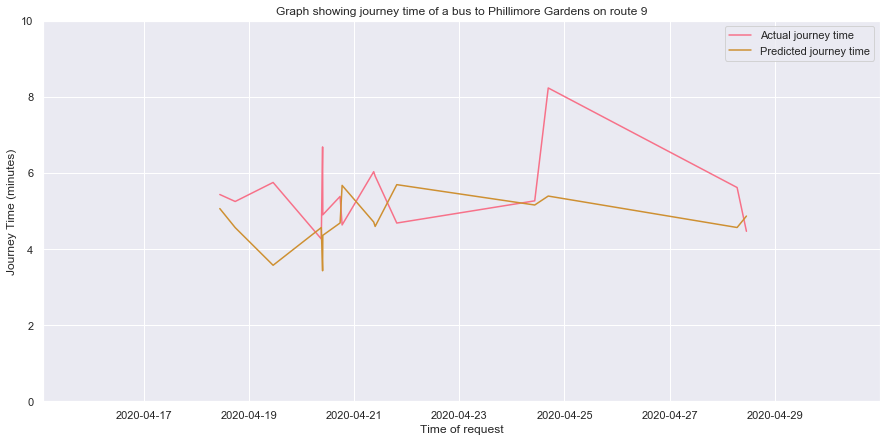

In [61]:
times_9 = [convert_time_to_datetime(t) for t in req_timesx_9]
actual_jrny_9 = [x.total_seconds() for x in accs_jrny_9]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_9, actual_jrny_9, label="Actual journey time")
ax.plot(times_9, preds_jrny_9, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 4, 30, 23, 59, 59)])
ax.set_ylim(0, 10)
ax.set_title("Graph showing journey time of a bus to Phillimore Gardens on route 9")
ax.legend()

plt.show()

In [58]:
actual_seconds_9 = [a.timestamp() for a in accs_9]
pred_seconds_9 = [p.timestamp() for p in preds_9]

evs9 = explained_variance_score(actual_seconds_9, pred_seconds_9)
mape9 = mean_absolute_error(actual_seconds_9, pred_seconds_9)

print("Explain variance score: ", evs9)
print("Mean absolute percentage error: ", mape9)

Explain variance score:  0.9999999192250055
Mean absolute percentage error:  61.244247388839725


### Putting it all together

The user gives their desired bus stop and bus route and gets a predicted arrival time back.

In [66]:
def get_pred_and_actual_arrival_time(route, stop):
    # Will need to do something about inbound or outbound
    
    df = data[route]

    stop_b_entries = df.loc[(df['bus_stop_name'] == stop) & (df['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    b_stop_index = stops_in_sequence_inbound.get(route).index(stop)
    a_stop_index = b_stop_index - 5 if (b_stop_index - 5) >= 0 else 0 
    a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
    print("{} to {}".format(a_stop_name, stop))
    
    stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
    [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
    
    # req_time = dt.datetime.now()
    req_time = "2020-04-20 15:30:00"
    
    print("Request time is ", req_time)
    
    pred_arr = 0
    
    while pred_arr == 0:
        pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a_entries, stop_b_entries, stop_a_id)
        print("Predicted journey time is ", (pred_jrny_time)/60)
        
        if pred_jrny_time == 0:
            print("Unable to find any journeys")
            pred_arr = 0
        else:
            pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a_entries, pred_jrny_time, most_recent_left)

        if pred_arr == 0:
            print("Couldn't find correlating leaving bus, go back 1 more stop")
            a_stop_index = a_stop_index - 1

            if a_stop_index < 0:
                print("No journeys found on entire route")
                return 0, 0

            a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
            stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
            [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
            print("{} to {}".format(a_stop_name, stop))

    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr = get_actual_times(stop_b_entries, req_time, bus_to_track, stop_b_id)
    
    if actual_arr is None:
        print("There is no bus arriving at req_time")
        return pred_arr, 0
    
    return pred_arr, actual_arr

In [67]:
user_route = "9"
user_stop = "Royal Albert Hall"

predicted_arr_time, actual_arr_time = get_pred_and_actual_arrival_time(user_route, user_stop)

Phillimore Gardens to Royal Albert Hall
Request time is  2020-04-20 15:30:00
Number of buses that arrived at stop b within the past 2 hours:  17
Number of buses that left stop a and have an id match:  101
Number of buses that have feasible journey times:  17
Predicted journey time is  5.303067993366501
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
The Design Museum to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  17
Number of buses that left stop a and have an id match:  101
Number of buses that have feasible journey times:  17
Predicted journey time is  6.86459369817579
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
Warwick Gardens to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  17
Number of buses that left stop a and have an id match:  101
Number of buses that have feasible journey tim